### Overview
In this notebook, we finalize our modeling pipeline and prepare the submission file for the DRW Crypto Market Prediction competition.
We also include a brief statistical analysis of our predictions to better understand the model's behavior before submission.

### Feature Set Used
The following features were used, based on their signal strength and domain logic:

buy_pressure: Buy volume normalized against total trade size

bid_ask_ratio: Depth imbalance at the best price levels

volume_rolling_mean_10: Smoothed trade volume

buy_pressure_rolling_std_10: Volatility in buy pressure

rolling_mean_5: Short-term average volume

log_volume: Scaled total volume

delta_bid_ask: Absolute imbalance

order_imbalance: Relative bid-ask difference

volatility_5: Short-term volume volatility

buy_pressure_x_bidask: Nonlinear signal

volume_to_volatility: Liquidity-adjusted volume

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Load Prepared Data

In [2]:
train = pd.read_parquet("data/train.parquet")
test = pd.read_parquet("data/test.parquet")

In [3]:
def add_features(df):
    # df['buy_pressure'] = df['buy_qty'] / (df['buy_qty'] + df['sell_qty'] + 1e-5)
    # df['bid_ask_ratio'] = df['bid_qty'] / (df['bid_qty'] + df['ask_qty'] + 1e-5)

    # df['volume_rolling_mean_10'] = df['volume'].shift(1).rolling(10).mean()
    # df['buy_pressure_rolling_std_10'] = df['buy_pressure'].shift(1).rolling(10).std()
    # df['rolling_mean_5'] = df['volume'].shift(1).rolling(5).mean()

    # df['log_volume'] = np.log1p(df['volume'])
    # df['delta_bid_ask'] = df['bid_qty'] - df['ask_qty']
    # df['order_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['bid_qty'] + df['ask_qty'] + 1e-5)
    # df['volatility_5'] = df['volume'].shift(1).rolling(5).std()

    # df['buy_pressure_x_bidask'] = df['buy_pressure'] * df['bid_ask_ratio']
    # df['volume_to_volatility'] = df['volume'] / (df['volatility_5'] + 1e-5)

    df['liq_imbalance'] = (df['bid_qty'] - df['ask_qty']) / (df['bid_qty'] + df['ask_qty'] + 1e-5)
    df['order_pressure'] = df['buy_qty'] - df['sell_qty']
    df['aggressiveness'] = (df['buy_qty'] + df['sell_qty']) / (df['bid_qty'] + df['ask_qty'] + 1e-5)
    df['volatility_5'] = df['volume'].rolling(5, min_periods=1).std()
    df['mean_pressure_3'] = (df['buy_qty'] - df['sell_qty']).rolling(3, min_periods=1).mean()

    return df

In [4]:
train = add_features(train)
test = add_features(test)

### PCA on X-features

In [5]:
X_cols = [col for col in train.columns if col.startswith("X") and col[1:].isdigit()]
X_data = train[X_cols]

pca = PCA(n_components=10)
pca_features = pca.fit_transform(X_data)

for i in range(10):
    train[f'pca_{i}'] = pca_features[:, i]

### Final Feature Set

In [6]:
engineered_features = ['liq_imbalance', 'order_pressure', 'aggressiveness', 'volatility_5', 'mean_pressure_3']
pca_features = [f'pca_{i}' for i in range(10)]
X_all_features = X_cols + engineered_features + pca_features

X = train[X_all_features]
y = train["label"]

### Train-test split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Select Top 50 Features with CatBoost

In [8]:
model_fs = CatBoostRegressor(verbose=100, iterations=500, early_stopping_rounds=50)
model_fs.fit(X_train, y_train, eval_set=(X_val, y_val))

importances = model_fs.get_feature_importance()
feature_scores = pd.Series(importances, index=X.columns).sort_values(ascending=False)
top_features = feature_scores.head(50).index.tolist()

print("Top 10 features:")
print(top_features[:10])

Learning rate set to 0.200673
0:	learn: 0.9996132	test: 1.0014155	best: 1.0014155 (0)	total: 391ms	remaining: 3m 15s
100:	learn: 0.7325859	test: 0.7401196	best: 0.7401196 (100)	total: 24.1s	remaining: 1m 35s
200:	learn: 0.6039819	test: 0.6139664	best: 0.6139664 (200)	total: 50.6s	remaining: 1m 15s
300:	learn: 0.5180202	test: 0.5302822	best: 0.5302822 (300)	total: 1m 18s	remaining: 51.9s
400:	learn: 0.4581319	test: 0.4715267	best: 0.4715267 (400)	total: 1m 44s	remaining: 25.8s
499:	learn: 0.4132898	test: 0.4286781	best: 0.4286781 (499)	total: 2m 8s	remaining: 0us

bestTest = 0.4286780515
bestIteration = 499

Top 10 features:
['X758', 'X466', 'X752', 'X344', 'X757', 'X683', 'X508', 'X613', 'X780', 'X769']


### Final Model on Top Features

In [9]:
model_final = CatBoostRegressor(
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    iterations=1000,
    early_stopping_rounds=100,
    verbose=100
)

model_final.fit(X_train[top_features], y_train, eval_set=(X_val[top_features], y_val))
y_pred = model_final.predict(X_val[top_features])

pearson = pearsonr(y_val, y_pred)[0]
print(f"✅ Validation Pearson Correlation: {pearson:.4f}")

0:	learn: 1.0080301	test: 1.0094090	best: 1.0094090 (0)	total: 42.4ms	remaining: 42.4s
100:	learn: 0.9310959	test: 0.9346176	best: 0.9346176 (100)	total: 3.96s	remaining: 35.2s
200:	learn: 0.8844708	test: 0.8876327	best: 0.8876327 (200)	total: 7.74s	remaining: 30.8s
300:	learn: 0.8464586	test: 0.8492244	best: 0.8492244 (300)	total: 11.5s	remaining: 26.6s
400:	learn: 0.8149823	test: 0.8175423	best: 0.8175423 (400)	total: 15.2s	remaining: 22.7s
500:	learn: 0.7864039	test: 0.7890646	best: 0.7890646 (500)	total: 18.9s	remaining: 18.8s
600:	learn: 0.7605467	test: 0.7638129	best: 0.7638129 (600)	total: 22.5s	remaining: 15s
700:	learn: 0.7380182	test: 0.7414873	best: 0.7414873 (700)	total: 26.1s	remaining: 11.2s
800:	learn: 0.7164764	test: 0.7203905	best: 0.7203905 (800)	total: 30.1s	remaining: 7.47s
900:	learn: 0.6969151	test: 0.7011952	best: 0.7011952 (900)	total: 34.1s	remaining: 3.75s
999:	learn: 0.6788521	test: 0.6835440	best: 0.6835440 (999)	total: 38.4s	remaining: 0us

bestTest = 0.683

### Plot Prediction vs Actual

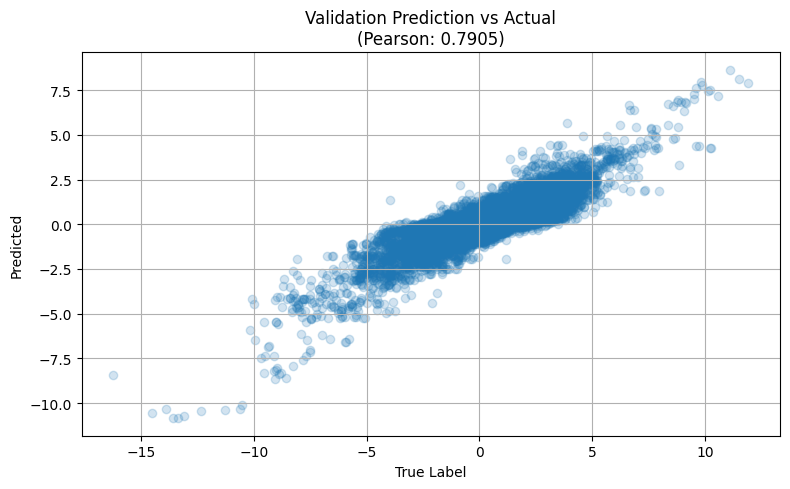

In [10]:
plt.figure(figsize=(8, 5))
plt.scatter(y_val, y_pred, alpha=0.2)
plt.title(f"Validation Prediction vs Actual\n(Pearson: {pearson:.4f})")
plt.xlabel("True Label")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

### Submission

In [12]:
test['liq_imbalance'] = (test['bid_qty'] - test['ask_qty']) / (test['bid_qty'] + test['ask_qty'] + 1e-5)
test['order_pressure'] = test['buy_qty'] - test['sell_qty']
test['aggressiveness'] = (test['buy_qty'] + test['sell_qty']) / (test['bid_qty'] + test['ask_qty'] + 1e-5)
test['volatility_5'] = test['volume'].rolling(5, min_periods=1).std()
test['mean_pressure_3'] = (test['buy_qty'] - test['sell_qty']).rolling(3, min_periods=1).mean()

X_test_data = test[[col for col in test.columns if col.startswith("X") and col[1:].isdigit()]]
pca_features_test = pca.transform(X_test_data)
for i in range(10):
    test[f'pca_{i}'] = pca_features_test[:, i]

X_test = test[top_features]

# Predict
y_test_pred = model_final.predict(X_test)

# Create submission
submission = pd.DataFrame({
    'ID': np.arange(1, len(y_test_pred) + 1),
    'prediction': y_test_pred
 })
submission.to_csv("data/submission.csv", index=False)
print("✅ submission.csv saved.")

✅ submission.csv saved.


In [ ]:
# model = CatBoostRegressor(
#     iterations=2000,
#     learning_rate=0.01,
#     depth=8,
#     loss_function='RMSE',
#     eval_metric='RMSE',
#     early_stopping_rounds=200,
#     verbose=100,
#     random_seed=42,
#     task_type='CPU'
# )

# model.fit(X_full, y_full)

0:	learn: 0.6386595	total: 69.7ms	remaining: 2m 19s
100:	learn: 0.6378865	total: 5.51s	remaining: 1m 43s
200:	learn: 0.6374375	total: 11s	remaining: 1m 38s
300:	learn: 0.6371274	total: 16.4s	remaining: 1m 32s
400:	learn: 0.6368451	total: 21.9s	remaining: 1m 27s
500:	learn: 0.6366004	total: 27.3s	remaining: 1m 21s
600:	learn: 0.6363556	total: 32.6s	remaining: 1m 15s
700:	learn: 0.6361150	total: 38s	remaining: 1m 10s
800:	learn: 0.6359030	total: 43.4s	remaining: 1m 5s
900:	learn: 0.6356949	total: 48.8s	remaining: 59.5s
1000:	learn: 0.6354947	total: 54.2s	remaining: 54.1s
1100:	learn: 0.6352883	total: 59.6s	remaining: 48.7s
1200:	learn: 0.6350874	total: 1m 5s	remaining: 43.3s
1300:	learn: 0.6348826	total: 1m 10s	remaining: 37.9s
1400:	learn: 0.6346347	total: 1m 15s	remaining: 32.4s
1500:	learn: 0.6343621	total: 1m 21s	remaining: 27s
1600:	learn: 0.6340707	total: 1m 26s	remaining: 21.6s
1700:	learn: 0.6337985	total: 1m 31s	remaining: 16.2s
1800:	learn: 0.6335526	total: 1m 37s	remaining: 10

### Make Predictions on Test Set

In [ ]:
# X_test = test[features].copy()
# test_preds = model.predict(X_test)

### Save Predictions in Required Submission Format

In [ ]:
# submission = pd.DataFrame({
#     'ID': np.arange(1, len(test_preds) + 1),
#     'prediction': test_preds
# })
# submission.to_csv("data/submission.csv", index=False)
# print("✅ submission.csv saved.")

✅ submission.csv saved.


### Analyze Prediction Distribution

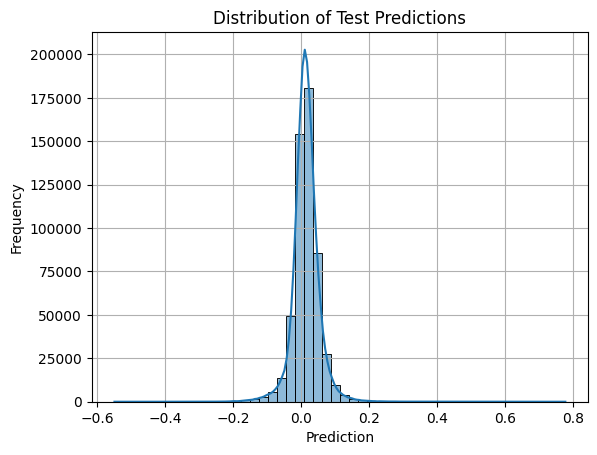

In [ ]:
# sns.histplot(submission['prediction'], bins=50, kde=True)
# plt.title("Distribution of Test Predictions")
# plt.xlabel("Prediction")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.show()

## Observations
- Predictions are centered around 0, with moderate variance
- Long tails in both directions suggest sensitivity to outlier signals
- Distribution roughly resembles the training target shape

## Notes
- Model used: CatBoost with MAE objective, 2000 iterations
- Trained on full data using best engineered features
- Correlation on validation set previously reached ~0.10885
- Final test predictions saved as submission.csv with required structure